In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon
%matplotlib inline

In [5]:
continental_us_bounds = Polygon([
    [
      -126.474609375,
      24.046463999666567
    ],
    [
      -64.775390625,
      24.046463999666567
    ],
    [
      -64.775390625,
      50.45750402042058
    ],
    [
      -126.474609375,
      50.45750402042058
    ],
    [
      -126.474609375,
      24.046463999666567
    ]
])

In [6]:
powerplants = pd.read_csv('powerplants.csv')
points = powerplants.apply(lambda x: Point(x.Longitude, x.Latitude), axis=1)
powerplants = gpd.GeoDataFrame(powerplants, geometry=points)
powerplants.crs = {'init': 'epsg:4326'}
powerplants = powerplants[powerplants.within(continental_us_bounds)].to_crs(epsg=5070)

In [141]:
stations = pd.read_csv('pm25_annual_fixed.csv')
points = stations.apply(lambda x: Point(x.Longitude, x.Latitude), axis=1)
stations = gpd.GeoDataFrame(stations, geometry=points)
stations.crs = {'init': 'epsg:4326'}
stations = stations[stations.within(continental_us_bounds)].to_crs(epsg=5070)

In [7]:
states = gpd.read_file('cb_2016_us_state_500k/cb_2016_us_state_500k.shp')
states = states[states.within(continental_us_bounds)].to_crs(epsg=5070)

In [19]:
nyc_districts = gpd.read_file('Community Districts/districts.shp')
nyc_districts = nyc_districts.to_crs(epsg=5070)

# 1. Do states with coal power plants have dirtier air?

In [195]:
states_coal = gpd.sjoin(
    states.reset_index(), 
    powerplants[powerplants['PrimSource'] == 'coal'], 
    op='intersects', 
    how='inner')

states['coal_powerplants'] = states_coal['index'].value_counts()

In [196]:
states_stations = gpd.sjoin(
    states.reset_index(),
    stations,
    op='intersects',
    how='inner')

states['pm25_average'] = states_stations.groupby('index')['Arithmetic Mean'].mean()

In [201]:
states[['NAME', 'coal_powerplants', 'pm25_average']].sort_values(['pm25_average', 'coal_powerplants'])

,NAME,coal_powerplants,pm25_average
11,Idaho,2.0,4.524000
31,Wyoming,12.0,4.886757
20,Nevada,3.0,5.594904
5,Colorado,10.0,5.868046
50,Virginia,10.0,6.125842
23,North Dakota,10.0,6.180000
47,Rhode Island,NaN,6.331694
22,New Mexico,3.0,6.390000
35,Kentucky,14.0,6.542209
7,Delaware,1.0,6.879896


In [213]:
states.sort_values('coal_powerplants', ascending=False).head(10)['pm25_average'].mean() > stations['Arithmetic Mean'].mean()

True

In [214]:
# Not necessarly but, on average, yes

# 2. Which power plants are within 75 miles of New York City?

In [21]:
states = states.to_crs({'proj':'merc'})
powerplants = powerplants.to_crs(states.crs)
nyc_districts = nyc_districts.to_crs(states.crs)

In [86]:
# 75 miles = 120701 meters
powerplants_nyc = powerplants[powerplants.buffer(120701).intersects(nyc_districts.unary_union)]

(-8531075.2682236601,
 -7950710.5387626458,
 4665357.6988135073,
 5227904.5153051754)

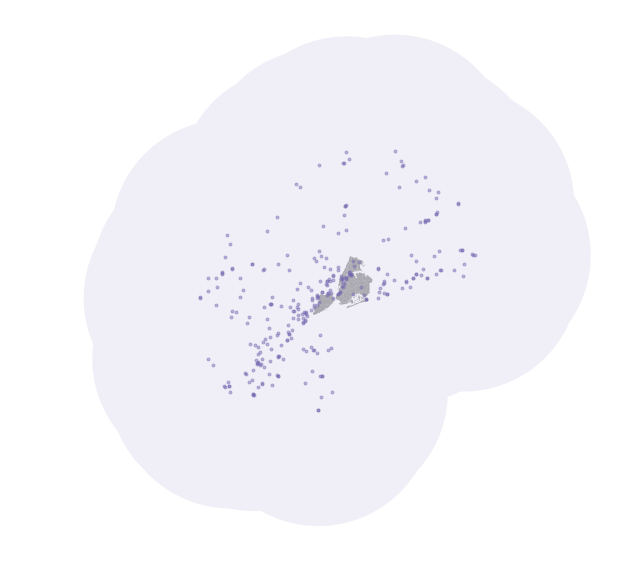

In [140]:
ax = nyc_districts.plot(
    color='#666666',
    linewidth=0,
    figsize=(10,10)
)

# Create a new dataframe to plot the powerplants' result of the union
powerplants_area = []
pd.DataFrame.from_dict(powerplants_area)
powerplants_area = gpd.GeoDataFrame(powerplants_area, geometry=[powerplants_nyc.buffer(120701).unary_union])
powerplants_area.plot(
    alpha=0.1,
    color='#756bb1',
    linewidth=0,
    ax=ax
)

powerplants_nyc.plot(
    color='#756bb1',
    markersize=3,
    linewidth=0,
    alpha=0.45,
    ax=ax)

ax.axis('off')

In [115]:
powerplants_nyc.head()

,Plant_Code,Plant_Name,Utility_Na,Utility_ID,sector_nam,City,County,Zip,Street_Add,PrimSource,...,Wind_MW,Geo_MW,Other_MW,source_des,tech_desc,Source,Period,Latitude,Longitude,geometry
341,539,Rocky River (CT),FirstLight Power Resources Services LLC,54895,IPP Non-CHP,New Milford,Litchfield,6776,200 Kent Road,pumped storage,...,0.0,NaN,NaN,Pumped Storage = 29.4 MW,Hydroelectric Pumped Storage,"EIA-860, EIA-860M and EIA-923",201607,41.582600,-73.434900,POINT (-8174735.674454964 5070292.25955708)
343,541,Bulls Bridge,FirstLight Power Resources Services LLC,54895,IPP Non-CHP,New Milford,Litchfield,6776,781 Kent Road,hydroelectric,...,0.0,NaN,NaN,Hydroelectric = 8.4 MW,Conventional Hydroelectric,"EIA-860, EIA-860M and EIA-923",201607,41.659046,-73.491984,POINT (-8181090.236267409 5081633.205464645)
344,542,Cos Cob,Connecticut Jet Power LLC,22379,IPP Non-CHP,Greenwich,Fairfield,6430,Sound Shore Drive,petroleum,...,0.0,NaN,NaN,Petroleum = 95.6 MW,Petroleum Liquids,"EIA-860, EIA-860M and EIA-923",201607,41.028900,-73.598900,POINT (-8192992.070945063 4988549.900230801)
345,544,Devon Station,Devon Power LLC,22350,IPP Non-CHP,Milford,New Haven,6460,734 Naugatuck Avenue,petroleum,...,0.0,NaN,NaN,Petroleum = 132.5 MW,Petroleum Liquids,"EIA-860, EIA-860M and EIA-923",201607,41.209797,-73.108976,POINT (-8138453.980737659 5015178.804320058)
350,552,Shepaug,FirstLight Power Resources Services LLC,54895,IPP Non-CHP,Southbury,New Haven,6488,2225 River Road,hydroelectric,...,0.0,NaN,NaN,Hydroelectric = 41.5 MW,Conventional Hydroelectric,"EIA-860, EIA-860M and EIA-923",201607,41.448420,-73.295321,POINT (-8159197.811249532 5050418.994864292)


# 3. Map all of the power plants in New York, New Jersey, Pennsylvania and Connecticut. Have a nice bottom layer of those 4 states.

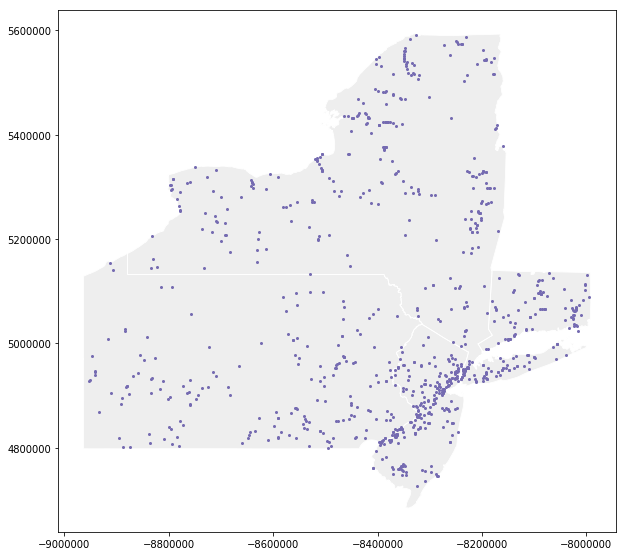

In [126]:
states_list = [
    'New York',
    'New Jersey',
    'Pennsylvania',
    'Connecticut'
]

listed_states = states[states['NAME'].isin(states_list)]

ax = listed_states.plot(
    color='#dedede',
    edgecolor='white',
    linewidth=0.85,
    figsize=(10,10)
)

powerplants_in_listed_states = gpd.sjoin(powerplants, listed_states, how='inner', op='within')
powerplants_in_listed_states.plot(color='#756bb1', ax=ax)

# 4. What is the most popular power source by state?

In [138]:
all_powerplants = gpd.sjoin(states, powerplants, how='inner', op='intersects')
(all_powerplants
 .groupby('NAME')
 ['PrimSource'].value_counts()
 .groupby(level=0, group_keys=False)
 .nlargest(1))

NAME                  PrimSource   
Alabama               hydroelectric     23
Arizona               solar             57
Arkansas              hydroelectric     19
California            solar            390
Colorado              hydroelectric     43
Connecticut           natural gas       34
Delaware              natural gas        9
District of Columbia  biomass            1
Florida               natural gas       64
Georgia               natural gas       30
Idaho                 hydroelectric     75
Illinois              natural gas       70
Indiana               solar             39
Iowa                  petroleum         93
Kansas                natural gas       60
Kentucky              coal              14
Louisiana             natural gas       56
Maine                 hydroelectric     52
Maryland              solar             25
Massachusetts         solar            134
Michigan              natural gas       57
Minnesota             wind             122
Mississippi       

# 5. Get the average (or highest/worst) PM2.5 within XXX miles of each power plant (you pick the distance). Is coal dirtier than other kinds of plants?

In [142]:
states = states.to_crs({'proj':'merc'})
stations = stations.to_crs(states.crs)
powerplants = powerplants.to_crs(states.crs)
nyc_districts = nyc_districts.to_crs(states.crs)

In [ ]:
powerplants_extract = powerplants[:500]

In [178]:
# 50km, only the first 500 powerplants
def does_intersects(row):
    return stations[stations.intersects(row.geometry.buffer(50000))]['Arithmetic Mean'].mean()

powerplants_extract['PM2.5'] = powerplants_extract.apply(does_intersects, axis=1)

In [179]:
powerplants_extract.groupby('PrimSource')['PM2.5'].mean()

PrimSource
biomass                NaN
coal              7.783847
geothermal             NaN
hydroelectric     8.104099
natural gas       8.130997
nuclear           8.811643
petroleum         7.904981
pumped storage    8.748148
wind                   NaN
Name: PM2.5, dtype: float64

# 6. Make a map of the power plants within 150 miles of New York City. I want it centered on New York City, zoomed in a good amount.

(-8528388.9024654236,
 -7981714.2452693852,
 4695909.2546054311,
 5224781.1374459323)

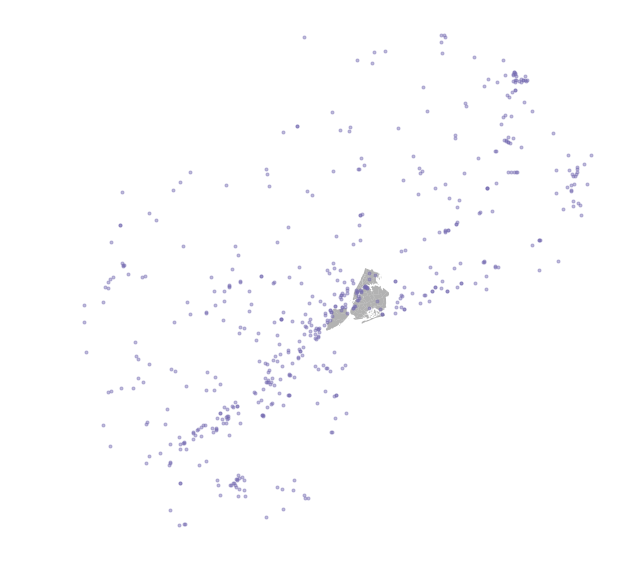

In [215]:
powerplants_nyc = powerplants[powerplants.buffer(241402).intersects(nyc_districts.unary_union)]

ax = nyc_districts.plot(
    color='#666666',
    linewidth=0,
    figsize=(10,10)
)

powerplants_nyc.plot(
    color='#756bb1',
    markersize=3,
    linewidth=0,
    alpha=0.45,
    ax=ax)

ax.axis('off')

# 7. Are places with below-average air quality closer to power plants?

In [216]:
# Average air quality
stations['Arithmetic Mean'].mean()

7.9684038761467884

In [235]:
# Places that do not cross the 50km buffer around poweplants
stations[~stations.buffer(50000).intersects(powerplants_extract.unary_union)]['Arithmetic Mean'].mean()

7.7779424832214765

In [236]:
# Places that cross the 50km buffer around poweplants
stations[stations.buffer(50000).intersects(powerplants_extract.unary_union)]['Arithmetic Mean'].mean()

8.3796900724637684

In [ ]:
# Yes